In [18]:
import os
os.environ['KAGGLE_USERNAME'] = '*'
os.environ['KAGGLE_KEY'] = '*'

In [19]:
!kaggle datasets download -d grassknoted/asl-alphabet

asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
import zipfile
with zipfile.ZipFile('asl-alphabet.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [21]:
import os
import shutil
import string

directory_path = '/content/asl_alphabet_train/asl_alphabet_train'  
for sn in string.ascii_uppercase:
    sp = os.path.join(directory_path, sn)  
    shutil.rmtree(sp) 


In [22]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import random

In [23]:
data_directory = "/content/asl_alphabet_train/asl_alphabet_train"
td = "/content/train"
vd = "/content/validation"
ttd = "/content/test"

os.makedirs(td, exist_ok=True)
os.makedirs(vd, exist_ok=True)
os.makedirs(ttd, exist_ok=True)

for folder_name in os.listdir(data_directory):
    folder_path = os.path.join(data_directory, folder_name)
    tsd = os.path.join(td, folder_name)
    vsd = os.path.join(vd, folder_name)
    ttsd = os.path.join(ttd, folder_name)
    os.makedirs(tsd, exist_ok=True)
    os.makedirs(vsd, exist_ok=True)
    os.makedirs(ttsd, exist_ok=True)
    file_list = os.listdir(folder_path)
    random.shuffle(file_list)
    num_files = len(file_list)
    num_train = int(0.7 * num_files)
    num_val = int(0.1 * num_files)
    num_test = int(0.2 * num_files)
    train_files = file_list[:num_train]
    val_files = file_list[num_train:num_train+num_val]
    test_files = file_list[num_train+num_val:num_train+num_val+num_test]
    for file_name in train_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(tsd, file_name)
        shutil.move(src_path, dst_path) 
    for file_name in val_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(vsd, file_name)
        shutil.move(src_path, dst_path)
    for file_name in test_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(ttsd, file_name)
        shutil.move(src_path, dst_path)


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
learning_rate = 0.001
num_epochs = 10
batch_size = 64
PATH = 'model.pth'

In [26]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [27]:
train_dataset = ImageFolder('/content/train', transform=transforms)
validation_dataset = ImageFolder('/content/validation', transform=transforms)
test_dataset = ImageFolder('/content/test', transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [28]:
import torchvision as torchvision
model = torchvision.models.mobilenet_v3_small(pretrained=False).to(device)
model.fc = nn.Linear(model.classifier[0].in_features, 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [29]:
for epoch in range(num_epochs):
    running_training_loss = 0.0
    running_training_accuracy = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)  
        labels = labels.to(device) 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()
        if (i+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
        _, preds = torch.max(outputs, 1)
        running_training_accuracy += torch.sum(preds == labels.data)
    
    epoch_training_loss = running_training_loss / len(train_loader)
    epoch_training_accuracy = running_training_accuracy / len(train_loader.dataset)
    print('Epoch [{}/{}], Training Loss: {}, Training Accuracy: {}'
          .format(epoch+1, num_epochs, epoch_training_loss, epoch_training_accuracy))
    torch.save(model.state_dict(), PATH)

Epoch [1/10], Step [50/129], Loss: 0.37959450483322144
Epoch [1/10], Step [100/129], Loss: 0.025352464988827705
Epoch [1/10], Training Loss: 0.6083049681958158, Training Accuracy: 0.7993665337562561
Epoch [2/10], Step [50/129], Loss: 0.018480494618415833
Epoch [2/10], Step [100/129], Loss: 0.002371241571381688
Epoch [2/10], Training Loss: 0.030876405386871465, Training Accuracy: 0.9898891448974609
Epoch [3/10], Step [50/129], Loss: 0.0001782176404958591
Epoch [3/10], Step [100/129], Loss: 0.00026443504611961544
Epoch [3/10], Training Loss: 0.0025134523394774798, Training Accuracy: 0.9993909001350403
Epoch [4/10], Step [50/129], Loss: 0.01945219747722149
Epoch [4/10], Step [100/129], Loss: 0.017481761053204536
Epoch [4/10], Training Loss: 0.010062915170385886, Training Accuracy: 0.9967108964920044
Epoch [5/10], Step [50/129], Loss: 0.00010352810932090506
Epoch [5/10], Step [100/129], Loss: 0.0002299926127307117
Epoch [5/10], Training Loss: 0.002147604463805537, Training Accuracy: 0.9995

In [31]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


model.to('cuda')


model = torch.nn.Sequential(*(list(model.children())[:-1]))


model.eval()

features = []
labels = []
for images, target in train_loader:
    images = images.to('cuda')
    with torch.no_grad():
        output = model(images)
        features.append(output.squeeze().cpu().numpy())
        labels.append(target.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000)
tsne_features = tsne.fit_transform(features)

target_names = list(train_dataset.class_to_idx.keys())


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8209 samples in 0.002s...
[t-SNE] Computed neighbors for 8209 samples in 2.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8209
[t-SNE] Computed conditional probabilities for sample 2000 / 8209
[t-SNE] Computed conditional probabilities for sample 3000 / 8209
[t-SNE] Computed conditional probabilities for sample 4000 / 8209
[t-SNE] Computed conditional probabilities for sample 5000 / 8209
[t-SNE] Computed conditional probabilities for sample 6000 / 8209
[t-SNE] Computed conditional probabilities for sample 7000 / 8209
[t-SNE] Computed conditional probabilities for sample 8000 / 8209
[t-SNE] Computed conditional probabilities for sample 8209 / 8209
[t-SNE] Mean sigma: 0.244922
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.790482
[t-SNE] KL divergence after 2000 iterations: 0.959234


<ipython-input-32-111e6578e571>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


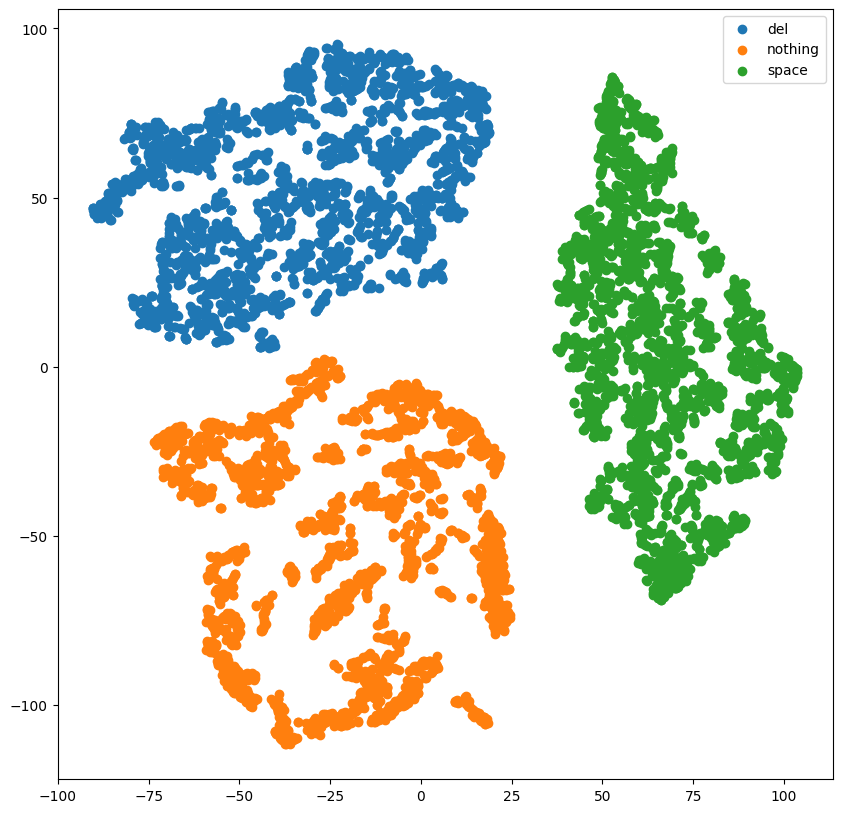

In [32]:
cmap = plt.cm.get_cmap('tab10')
plt.figure(figsize=(10, 10))
for i, target_name in enumerate(target_names):
    indices = labels == i
    color = cmap(i)  
    plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], color=color, label=target_name)
plt.legend()
plt.show()